In [1]:
# SIFT
import numpy as np
import imutils
import cv2
import time


class Stitcher:
    def __init__(self):
        # determine if we are using OpenCV v3.X
        self.isv3 = imutils.is_cv3()

    def stitch(self, images, ratio=0.75, reprojThresh=4.0,
               showMatches=False):
        # 解压缩图像，然后从局部不变信息中检测关键点并提取

        (imageB, imageA) = images
        start = time.time()
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        end = time.time()
        print('%.5f s' % (end - start))

        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # 从两张图片中匹配特征
        start = time.time()
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
        end = time.time()
        print('%.5f s' % (end - start))

        # 如果匹配项为“无”，则没有足够的匹配项
        if M is None:
            return None

        # 否则缝合图像
        (matches, H, status) = M
        start = time.time()
        result = cv2.warpPerspective(imageA, H,
                                     (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        end = time.time()
        print('%.5f s' % (end - start))

        # 检查关键点匹配是否应该可视化
        if showMatches:
            start = time.time()
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            end = time.time()
            print('%.5f s' % (end - start))
            # 返回拼接图像和可视化的元组
            return (result, vis)

        # 返回拼接图像
        return result

    # 接收照片，检测关键点和提取局部不变特征
    # 用到了高斯差分（Difference of Gaussian (DoG)）关键点检测，和SIFT特征提取
    # detectAndCompute方法用来处理提取关键点和特征
    # 返回一系列的关键点
    def detectAndDescribe(self, image):
        # 将图像转换为灰度图像
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # check to see if we are using OpenCV 3.X
        if self.isv3:
            # 从图像中检测和提取特征
            descriptor = cv2.xfeatures2d.SIFT_create()
            (kps, features) = descriptor.detectAndCompute(image, None)

        # otherwise, we are using OpenCV 2.4.X
        else:
            # 检测图像中的关键点
            detector = cv2.FeatureDetector_create("SIFT")
            kps = detector.detect(gray)

            # 从图像中提取特征
            extractor = cv2.DescriptorExtractor_create("SIFT")
            (kps, features) = extractor.compute(gray, kps)

        # 将关键点从KeyPoint对象转换为NumPy数组
        kps = np.float32([kp.pt for kp in kps])

        # 返回关键点和特征的元组
        return (kps, features)

    # matchKeypoints方法需要四个参数，第一张图片的关键点和特征向量，第二张图片的关键点特征向量。
    # David Lowe’s ratio测试变量和RANSAC重投影门限也应该被提供。
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
                       ratio, reprojThresh):
        # 计算原始匹配并初始化实际匹配的列表
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # 在原始匹配上循环
        for m in rawMatches:
            # 确保距离在一定的比率内（即Lowe比率测试）
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # 计算单应性至少需要4个匹配
        if len(matches) > 4:
            # 构造两组点
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # 计算两组点之间的单应性
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                                             reprojThresh)

            # 返回匹配项以及同形矩阵和每个匹配点的状态
            return (matches, H, status)

        # 否则，无法计算同形
        return None

    # 连线画出两幅图的匹配
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # 初始化输出可视化图像
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully matched
            if s == 1:
                # draw the match
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # return the visualization
        return vis


if __name__ == '__main__':
    # load the two images and resize them to have a width of 400 pixels
    # (for faster processing)
    imageA = cv2.imread('test1.jpg')
    imageB = cv2.imread('test2.jpg')
    # imageA = imutils.resize(imageA, width=400)
    # imageB = imutils.resize(imageB, width=400)
    # stitch the images together to create a panorama
    # showMatches=True 展示两幅图像特征的匹配,返回vis
    start = time.time()
    stitcher = Stitcher()
    (result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)
    # show the images
    end = time.time()
    print('%.5f s' % (end - start))
    cv2.imwrite('vis1.jpg', vis)
    cv2.imwrite('stitch.jpg', result)

1.24036 s
0.24591 s
0.04012 s
0.00799 s
2.09203 s


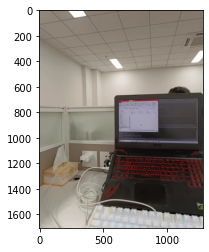

In [3]:
import cv2
from  matplotlib import pyplot as plt

im = cv2.imread("test1.jpg",1)	# load image as bgr
im2 = im[:,:,::-1] 	# transform image to rgb
plt.imshow(im2)
plt.show()

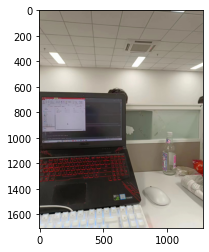

In [4]:
import cv2
from  matplotlib import pyplot as plt

im = cv2.imread("test2.jpg",1)	# load image as bgr
im2 = im[:,:,::-1] 	# transform image to rgb
plt.imshow(im2)
plt.show()

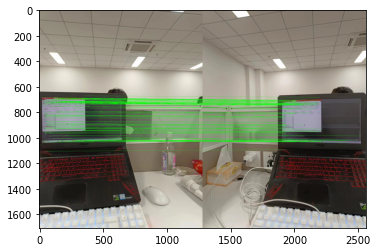

In [6]:
import cv2
from  matplotlib import pyplot as plt

im = cv2.imread("vis1.jpg",1)	# load image as bgr
im2 = im[:,:,::-1] 	# transform image to rgb
plt.imshow(im2)
plt.show()

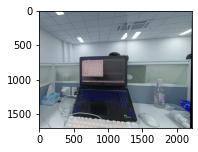

True

In [5]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def remove_the_blackborder(image):

    image = cv2.imread(image)      #读取图片
    img = cv2.medianBlur(image, 5) #中值滤波，去除黑色边际中可能含有的噪声干扰
    b = cv2.threshold(img, 3, 255, cv2.THRESH_BINARY) #调整裁剪效果
    binary_image = b[1]            #二值图--具有三通道
    binary_image = cv2.cvtColor(binary_image,cv2.COLOR_BGR2GRAY)
    # print(binary_image.shape)     #改为单通道
 
    edges_y, edges_x = np.where(binary_image==255) ##h, w
    bottom = min(edges_y)             
    top = max(edges_y) 
    height = top - bottom            
                                   
    left = min(edges_x)           
    right = max(edges_x)             
    height = top - bottom 
    width = right - left

    res_image = image[bottom:bottom+height, left:left+width]

    plt.figure()
    #plt.subplot(1,2,1)
    #plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(res_image)
    plt.show()
    return res_image                                          
 
                                                           
img = remove_the_blackborder("stitch.jpg")
cv2.imwrite("result.jpg", img)